## 라이브러리 삽입

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product
import os

from xgboost import XGBRegressor
from xgboost import plot_importance

In [2]:
test = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/test.csv')
train = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/sales_train.csv')
shops = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/shops.csv')
items = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/items.csv')
cats = pd.read_csv(os.getenv('HOME')+'/aiffel/kaggle_AIS3/item_categories.csv')

In [3]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 이상치 제거

<AxesSubplot:xlabel='item_price'>

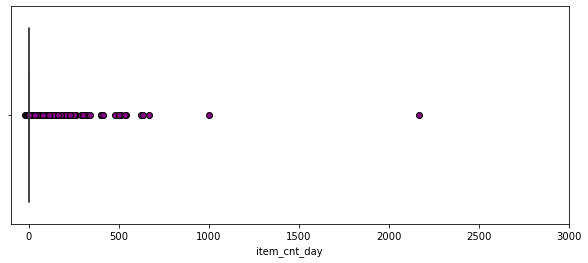

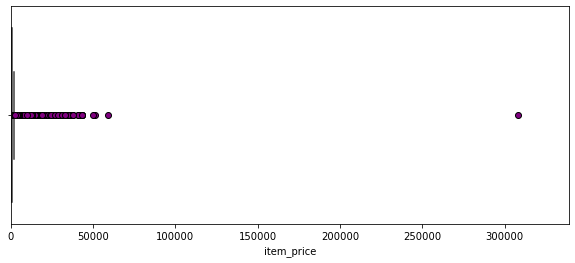

In [4]:
# 출처: Future Sales3
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [6]:
# 판매량과 가격의 이상치를 제거해 준다.
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

## shop 데이터 정리

In [7]:
# shops 이름 정리
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [8]:
# shop city column 추가
from sklearn.preprocessing import LabelEncoder
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_name", "shop_id", "shop_city"]]

## item category 데이터 정리

In [9]:

cats["main_cat_id"] = cats.item_category_name.str.split("-").map( lambda x: x[0] )
cats["main_cat_id"] = LabelEncoder().fit_transform( cats.main_cat_id )
cats = cats[["item_category_name", "item_category_id", "main_cat_id"]]

In [10]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [11]:
cats[0:20]

,item_category_name,item_category_id,main_cat_id
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
5,Аксессуары - PSVita,5,1
6,Аксессуары - XBOX 360,6,1
7,Аксессуары - XBOX ONE,7,1
8,Билеты (Цифра),8,2
9,Доставка товара,9,3


In [12]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [13]:
items = pd.merge(items, cats, on='item_category_id', how='left')

In [14]:
items=items.drop('item_category_name',axis=1)

In [15]:
items=items.drop('item_name',axis=1)

In [16]:
items

,item_id,item_category_id,main_cat_id
0,0,40,11
1,1,76,15
2,2,40,11
3,3,40,11
4,4,40,11
...,...,...,...
22165,22165,31,8
22166,22166,54,12
22167,22167,49,12
22168,22168,62,14


In [17]:
train=pd.merge(train,items, on ='item_id', how ='left')

In [18]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_cat_id
0,02.01.2013,0,59,22154,999.00,1.0,37,11
1,03.01.2013,0,25,2552,899.00,1.0,58,13
2,05.01.2013,0,25,2552,899.00,-1.0,58,13
3,06.01.2013,0,25,2554,1709.05,1.0,58,13
4,15.01.2013,0,25,2555,1099.00,1.0,56,13
...,...,...,...,...,...,...,...,...
2935841,10.10.2015,33,25,7409,299.00,1.0,55,13
2935842,09.10.2015,33,25,7460,299.00,1.0,55,13
2935843,14.10.2015,33,25,7459,349.00,1.0,55,13
2935844,22.10.2015,33,25,7440,299.00,1.0,57,13


In [19]:
# https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1
# Feature engineering, LightGBM - Top 1%
train = train.groupby(['date_block_num','shop_id','item_id','item_category_id','main_cat_id']).agg({'item_cnt_day': ['sum']})
train.columns = ['item_cnt_month']
train.reset_index(inplace=True)

In [20]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,27,19,5,1.0
1,0,2,33,37,11,1.0
2,0,2,317,45,12,1.0
3,0,2,438,45,12,1.0
4,0,2,471,49,12,2.0
...,...,...,...,...,...,...
1608265,33,59,22087,83,20,6.0
1608266,33,59,22088,83,20,2.0
1608267,33,59,22091,83,20,1.0
1608268,33,59,22100,42,12,1.0


In [21]:
train['item_cnt_month'] = (train['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [22]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,27,19,5,1.0
1,0,2,33,37,11,1.0
2,0,2,317,45,12,1.0
3,0,2,438,45,12,1.0
4,0,2,471,49,12,2.0
...,...,...,...,...,...,...
1608265,33,59,22087,83,20,6.0
1608266,33,59,22088,83,20,2.0
1608267,33,59,22091,83,20,1.0
1608268,33,59,22100,42,12,1.0


In [23]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648


In [24]:
test['date_block_num']='34'

In [25]:
test

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34
...,...,...,...,...
214195,214195,45,18454,34
214196,214196,45,16188,34
214197,214197,45,15757,34
214198,214198,45,19648,34


In [26]:
test=pd.merge(test,items, on ='item_id', how ='left')

In [27]:
test

,ID,shop_id,item_id,date_block_num,item_category_id,main_cat_id
0,0,5,5037,34,19,5
1,1,5,5320,34,55,13
2,2,5,5233,34,19,5
3,3,5,5232,34,23,5
4,4,5,5268,34,20,5
...,...,...,...,...,...,...
214195,214195,45,18454,34,55,13
214196,214196,45,16188,34,64,14
214197,214197,45,15757,34,55,13
214198,214198,45,19648,34,40,11


In [28]:
test= test[['date_block_num','shop_id','item_id','item_category_id','main_cat_id']]

In [29]:
test

,date_block_num,shop_id,item_id,item_category_id,main_cat_id
0,34,5,5037,19,5
1,34,5,5320,55,13
2,34,5,5233,19,5
3,34,5,5232,23,5
4,34,5,5268,20,5
...,...,...,...,...,...
214195,34,45,18454,55,13
214196,34,45,16188,64,14
214197,34,45,15757,55,13
214198,34,45,19648,40,11


In [30]:
# https://www.kaggle.com/alexanderossipov/predict-future-sales-ensemble
# Predict Future Sales: ensemble
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
y_train = train[train.date_block_num < 33]['item_cnt_month']
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
y_valid = train[train.date_block_num == 33]['item_cnt_month']
X_test = test

In [31]:
del train
del test

In [44]:
X_test['date_block_num'] = pd.to_numeric(X_test['date_block_num'])

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [45]:
X_test

,date_block_num,shop_id,item_id,item_category_id,main_cat_id
0,34,5,5037,19,5
1,34,5,5320,55,13
2,34,5,5233,19,5
3,34,5,5232,23,5
4,34,5,5268,20,5
...,...,...,...,...,...
214195,34,45,18454,55,13
214196,34,45,16188,64,14
214197,34,45,15757,55,13
214198,34,45,19648,40,11


In [33]:
cat_feats = ['shop_id','item_id','item_category_id','main_cat_id']

In [39]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

model_lgbm = LGBMRegressor(
    max_depth = 10,
    n_estimators = 3000,
    colsample_bytree=0.7,
    learning_rate = 0.009,
    min_child_weight = 300,
    reg_alpha = 0.1,
    reg_lambda = 1,
    random_state = 2020,
)

model_lgbm.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=10, 
    early_stopping_rounds = 40) 


prediction_lgbm = model_lgbm.predict(X_valid)
print(mean_squared_error(y_valid, prediction_lgbm, squared=False))

np.save('prediction_lgbm.npy', prediction_lgbm)
pickle.dump(model_lgbm, open('model_lgbm.pkl', 'wb'))

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 40 rounds
[10]	training's rmse: 2.55403	training's l2: 6.52306	valid_1's rmse: 2.51522	valid_1's l2: 6.32632
[20]	training's rmse: 2.53163	training's l2: 6.40917	valid_1's rmse: 2.49492	valid_1's l2: 6.22462
[30]	training's rmse: 2.51099	training's l2: 6.30506	valid_1's rmse: 2.47564	valid_1's l2: 6.12878
[40]	training's rmse: 2.49364	training's l2: 6.21825	valid_1's rmse: 2.46045	valid_1's l2: 6.05383
[50]	training's rmse: 2.47864	training's l2: 6.14367	valid_1's rmse: 2.44675	valid_1's l2: 5.98661
[60]	training's rmse: 2.46632	training's l2: 6.08272	valid_1's rmse: 2.43606	valid_1's l2: 5.93439
[70]	training's rmse: 2.45563	training's l2: 6.03011	valid_1's rmse: 2.4278	valid_1's l2: 5.89421
[80]	training's rmse: 2.44603	training's l2: 5.98305	valid_1's rmse: 2.41988	valid_1's l2: 5.8558
[90]	training's rms

[820]	training's rmse: 2.27724	training's l2: 5.18582	valid_1's rmse: 2.27873	valid_1's l2: 5.19263
[830]	training's rmse: 2.27636	training's l2: 5.1818	valid_1's rmse: 2.27756	valid_1's l2: 5.18729
[840]	training's rmse: 2.27531	training's l2: 5.17704	valid_1's rmse: 2.27671	valid_1's l2: 5.18339
[850]	training's rmse: 2.27451	training's l2: 5.17342	valid_1's rmse: 2.2762	valid_1's l2: 5.1811
[860]	training's rmse: 2.2736	training's l2: 5.16925	valid_1's rmse: 2.27464	valid_1's l2: 5.17397
[870]	training's rmse: 2.27254	training's l2: 5.16442	valid_1's rmse: 2.27298	valid_1's l2: 5.16643
[880]	training's rmse: 2.27156	training's l2: 5.15998	valid_1's rmse: 2.27276	valid_1's l2: 5.16544
[890]	training's rmse: 2.2708	training's l2: 5.15651	valid_1's rmse: 2.27218	valid_1's l2: 5.16282
[900]	training's rmse: 2.2699	training's l2: 5.15246	valid_1's rmse: 2.27133	valid_1's l2: 5.15893
[910]	training's rmse: 2.26906	training's l2: 5.14864	valid_1's rmse: 2.27003	valid_1's l2: 5.15306
[920]	

[1640]	training's rmse: 2.22165	training's l2: 4.93571	valid_1's rmse: 2.21304	valid_1's l2: 4.89754
[1650]	training's rmse: 2.22123	training's l2: 4.93385	valid_1's rmse: 2.21277	valid_1's l2: 4.89634
[1660]	training's rmse: 2.22081	training's l2: 4.932	valid_1's rmse: 2.21257	valid_1's l2: 4.89546
[1670]	training's rmse: 2.22037	training's l2: 4.93004	valid_1's rmse: 2.21239	valid_1's l2: 4.89467
[1680]	training's rmse: 2.21986	training's l2: 4.92776	valid_1's rmse: 2.21215	valid_1's l2: 4.89362
[1690]	training's rmse: 2.21952	training's l2: 4.92627	valid_1's rmse: 2.21183	valid_1's l2: 4.89218
[1700]	training's rmse: 2.21912	training's l2: 4.92448	valid_1's rmse: 2.21151	valid_1's l2: 4.89078
[1710]	training's rmse: 2.21869	training's l2: 4.92258	valid_1's rmse: 2.21069	valid_1's l2: 4.88717
[1720]	training's rmse: 2.21826	training's l2: 4.92067	valid_1's rmse: 2.20986	valid_1's l2: 4.88349
[1730]	training's rmse: 2.21789	training's l2: 4.91902	valid_1's rmse: 2.20928	valid_1's l2: 

[2460]	training's rmse: 2.18983	training's l2: 4.79533	valid_1's rmse: 2.1868	valid_1's l2: 4.78207
[2470]	training's rmse: 2.18952	training's l2: 4.79398	valid_1's rmse: 2.18657	valid_1's l2: 4.7811
[2480]	training's rmse: 2.18914	training's l2: 4.79231	valid_1's rmse: 2.18646	valid_1's l2: 4.78061
[2490]	training's rmse: 2.18882	training's l2: 4.79093	valid_1's rmse: 2.18617	valid_1's l2: 4.77932
[2500]	training's rmse: 2.18853	training's l2: 4.78965	valid_1's rmse: 2.18604	valid_1's l2: 4.77879
[2510]	training's rmse: 2.18812	training's l2: 4.78786	valid_1's rmse: 2.18582	valid_1's l2: 4.7778
[2520]	training's rmse: 2.18787	training's l2: 4.78679	valid_1's rmse: 2.18563	valid_1's l2: 4.77697
[2530]	training's rmse: 2.18758	training's l2: 4.78551	valid_1's rmse: 2.18573	valid_1's l2: 4.77739
[2540]	training's rmse: 2.18733	training's l2: 4.7844	valid_1's rmse: 2.18559	valid_1's l2: 4.77682
[2550]	training's rmse: 2.18701	training's l2: 4.78302	valid_1's rmse: 2.18554	valid_1's l2: 4.

In [40]:
prediction_lgbm = model_lgbm.predict(X_valid)
print(mean_squared_error(y_valid, prediction_lgbm, squared=False))

2.178804903042307


In [46]:
prediction = model_lgbm.predict(X_test)

In [47]:
prediction_lgbm = prediction

submission = pd.DataFrame({
    "ID": np.arange(prediction.shape[0]), 
    "item_cnt_month": prediction.clip(0, 20)
})
submission.to_csv('submission_lgbm.csv', index=False)

In [50]:
model = XGBRegressor(
    max_depth=17,
    n_estimators=3000,
    min_child_weight=249, 
    learning_rate = 0.009,
    colsample_bytree=0.9, 
    subsample=0.7, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, y_train), (X_valid, y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[0]	validation_0-rmse:2.98717	validation_1-rmse:2.91543
[1]	validation_0-rmse:2.97498	validation_1-rmse:2.90505
[2]	validation_0-rmse:2.96264	validation_1-rmse:2.89514
[3]	validation_0-rmse:2.95216	validation_1-rmse:2.88652
[4]	validation_0-rmse:2.94082	validation_1-rmse:2.87450
[5]	validation_0-rmse:2.92960	validation_1-rmse:2.86435
[6]	validation_0-rmse:2.91843	validation_1-rmse:2.85463
[7]	validation_0-rmse:2.90718	validation_1-rmse:2.84483
[8]	validation_0-rmse:2.89602	validation_1-rmse:2.83543
[9]	validation_0-rmse:2.88578	validation_1-rmse:2.82469
[10]	validation_0-rmse:2.87480	validation_1-rmse:2.81582
[11]	validation_0-rmse:2.86573	validation_1-rmse:2.80814
[12]	validation_0-rmse:2.85496	validation_1-rmse:2.79945
[13]	validation_0-rmse:2.84529	validation_1-rmse:2.78919
[14]	validation_0-rmse:2.83579	validation_1-rmse:2.77921
[15]	validation_0-rmse:2.82715	validation_1-rmse:2.77170
[16]	validation_0-rmse:2.81671	validation_1-rmse:2.76344
[17]	validation_0-rmse:2.80832	validation

[144]	validation_0-rmse:2.22902	validation_1-rmse:2.29168
[145]	validation_0-rmse:2.22736	validation_1-rmse:2.28993
[146]	validation_0-rmse:2.22597	validation_1-rmse:2.28888
[147]	validation_0-rmse:2.22397	validation_1-rmse:2.28780
[148]	validation_0-rmse:2.22180	validation_1-rmse:2.28699
[149]	validation_0-rmse:2.22021	validation_1-rmse:2.28542
[150]	validation_0-rmse:2.21809	validation_1-rmse:2.28415
[151]	validation_0-rmse:2.21648	validation_1-rmse:2.28268
[152]	validation_0-rmse:2.21426	validation_1-rmse:2.28155
[153]	validation_0-rmse:2.21274	validation_1-rmse:2.27988
[154]	validation_0-rmse:2.21062	validation_1-rmse:2.27879
[155]	validation_0-rmse:2.20913	validation_1-rmse:2.27732
[156]	validation_0-rmse:2.20789	validation_1-rmse:2.27635
[157]	validation_0-rmse:2.20578	validation_1-rmse:2.27554
[158]	validation_0-rmse:2.20438	validation_1-rmse:2.27427
[159]	validation_0-rmse:2.20249	validation_1-rmse:2.27348
[160]	validation_0-rmse:2.20096	validation_1-rmse:2.27261
[161]	validati

[286]	validation_0-rmse:2.08431	validation_1-rmse:2.18402
[287]	validation_0-rmse:2.08404	validation_1-rmse:2.18385
[288]	validation_0-rmse:2.08327	validation_1-rmse:2.18380
[289]	validation_0-rmse:2.08281	validation_1-rmse:2.18335
[290]	validation_0-rmse:2.08255	validation_1-rmse:2.18322
[291]	validation_0-rmse:2.08174	validation_1-rmse:2.18331
[292]	validation_0-rmse:2.08115	validation_1-rmse:2.18320
[293]	validation_0-rmse:2.08087	validation_1-rmse:2.18311
[294]	validation_0-rmse:2.07998	validation_1-rmse:2.18301
[295]	validation_0-rmse:2.07893	validation_1-rmse:2.18302
[296]	validation_0-rmse:2.07866	validation_1-rmse:2.18290
[297]	validation_0-rmse:2.07824	validation_1-rmse:2.18237
[298]	validation_0-rmse:2.07782	validation_1-rmse:2.18202
[299]	validation_0-rmse:2.07704	validation_1-rmse:2.18160
[300]	validation_0-rmse:2.07609	validation_1-rmse:2.18068
[301]	validation_0-rmse:2.07581	validation_1-rmse:2.18045
[302]	validation_0-rmse:2.07486	validation_1-rmse:2.18034
[303]	validati

[428]	validation_0-rmse:2.01812	validation_1-rmse:2.14137
[429]	validation_0-rmse:2.01787	validation_1-rmse:2.14080
[430]	validation_0-rmse:2.01730	validation_1-rmse:2.14097
[431]	validation_0-rmse:2.01715	validation_1-rmse:2.14057
[432]	validation_0-rmse:2.01689	validation_1-rmse:2.14009
[433]	validation_0-rmse:2.01653	validation_1-rmse:2.14002
[434]	validation_0-rmse:2.01640	validation_1-rmse:2.13984
[435]	validation_0-rmse:2.01617	validation_1-rmse:2.13936
[436]	validation_0-rmse:2.01580	validation_1-rmse:2.13939
[437]	validation_0-rmse:2.01566	validation_1-rmse:2.13932
[438]	validation_0-rmse:2.01525	validation_1-rmse:2.13940
[439]	validation_0-rmse:2.01504	validation_1-rmse:2.13888
[440]	validation_0-rmse:2.01440	validation_1-rmse:2.13853
[441]	validation_0-rmse:2.01423	validation_1-rmse:2.13856
[442]	validation_0-rmse:2.01383	validation_1-rmse:2.13858
[443]	validation_0-rmse:2.01353	validation_1-rmse:2.13814
[444]	validation_0-rmse:2.01332	validation_1-rmse:2.13800
[445]	validati

[570]	validation_0-rmse:1.98105	validation_1-rmse:2.12510
[571]	validation_0-rmse:1.98097	validation_1-rmse:2.12511
[572]	validation_0-rmse:1.98090	validation_1-rmse:2.12497
[573]	validation_0-rmse:1.98054	validation_1-rmse:2.12497
[574]	validation_0-rmse:1.98047	validation_1-rmse:2.12488
[575]	validation_0-rmse:1.98045	validation_1-rmse:2.12487
[576]	validation_0-rmse:1.98027	validation_1-rmse:2.12457
[577]	validation_0-rmse:1.98014	validation_1-rmse:2.12445
[578]	validation_0-rmse:1.98007	validation_1-rmse:2.12444
[579]	validation_0-rmse:1.97985	validation_1-rmse:2.12463
[580]	validation_0-rmse:1.97970	validation_1-rmse:2.12433
[581]	validation_0-rmse:1.97944	validation_1-rmse:2.12438
[582]	validation_0-rmse:1.97906	validation_1-rmse:2.12422
[583]	validation_0-rmse:1.97890	validation_1-rmse:2.12422
[584]	validation_0-rmse:1.97855	validation_1-rmse:2.12401
[585]	validation_0-rmse:1.97839	validation_1-rmse:2.12399
[586]	validation_0-rmse:1.97830	validation_1-rmse:2.12396
[587]	validati

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.009, max_delta_step=0, max_depth=17,
             min_child_weight=249, missing=nan, monotone_constraints='()',
             n_estimators=3000, n_jobs=12, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [52]:
y_pred = model.predict(X_valid).clip(0, 20)
y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": X_test.index, 
    "item_cnt_month": y_test
})
submission.to_csv('boost_submission.csv', index=False)

###########################################
이뒤로는 그냥 참고

In [50]:
monthly_sales1=train.groupby(["date_block_num","shop_id","item_id","item_category_id","main_cat_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [51]:
monthly_sales1

item_price  \
date_block_num shop_id item_id item_category_id main_cat_id               
0              2       27      19               5                2499.0   
                       33      37               11                499.0   
                       317     45               12                299.0   
                       438     45               12                299.0   
                       471     49               12                399.0   
...                                                                 ...   
33             59      22087   83               20                119.0   
                       22088   83               20                119.0   
                       22091   83               20                179.0   
                       22100   42               12                629.0   
                       22102   42               12               1250.0   

                                                             item_cnt_day  
date_block_num shop_id item_id item_category_id main_cat_id                
0              2       27      19               5                     1.0  
                       33      37               11                    1.0  
                       317     45               12                    1.0  
                       438     45               12                    1.0  
                       471     49               12                    2.0  
...                                                                   ...  
33             59      22087   83               20                    6.0  
                       22088   83               20                    2.0  
                       22091   83               20                    1.0  
                       22100   42               12                    1.0  
                       22102   42               12                    1.0  

[1608270 rows x 2 columns]

In [55]:
monthly_sales1=train.groupby(["date_block_num","shop_id","item_id","item_category_id","main_cat_id"])["item_cnt_day"].sum()

In [57]:
ms = pd.DataFrame(monthly_sales1)

In [58]:
ms

item_cnt_day
date_block_num shop_id item_id item_category_id main_cat_id              
0              2       27      19               5                     1.0
                       33      37               11                    1.0
                       317     45               12                    1.0
                       438     45               12                    1.0
                       471     49               12                    2.0
...                                                                   ...
33             59      22087   83               20                    6.0
                       22088   83               20                    2.0
                       22091   83               20                    1.0
                       22100   42               12                    1.0
                       22102   42               12                    1.0

[1608270 rows x 1 columns]

In [33]:
monthly_sales2=train.groupby(["date_block_num","shop_id","main_cat_id",])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [34]:
monthly_sales2.head(20)

item_price  item_cnt_day
date_block_num shop_id main_cat_id                            
0              2       1             1672.951356          66.0
                       4            12058.394737          20.0
                       5             1392.691043         240.0
                       8              485.297026         263.0
                       9             1665.666667           3.0
                       11             365.109146         248.0
                       12             326.185185          27.0
                       13             268.821429          56.0
                       14             621.953804         102.0
                       15            1098.527848          88.0
                       16              99.000000           1.0
                       19              37.500000          22.0
                       20              90.833333          10.0
               3       1             1216.056875          32.0
                       4            11650.340000           5.0
                       5             1376.851139         159.0
                       8              442.337553         246.0
                       9             1399.333333           3.0
                       11             359.825291         213.0
                       13             347.414634          82.0

In [22]:
monthly_sales3=train.groupby(["date_block_num","shop_id"])[
    "item_price","item_cnt_day"].agg({"item_price":"mean","item_cnt_day":"sum"})

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [23]:
monthly_sales3

item_price  item_cnt_day
date_block_num shop_id                           
0              2         960.654952        1146.0
               3         734.329786         767.0
               4         702.325446        2114.0
               6         755.732835        3686.0
               7         749.145830        2495.0
...                             ...           ...
33             55        751.103833        1972.0
               56       1089.635193        1263.0
               57       1061.750358        2316.0
               58       1211.920188        1446.0
               59       1129.254066         790.0

[1575 rows x 2 columns]

In [26]:
monthly_sales4=train.groupby(["date_block_num"])[
    "item_cnt_day"].sum()

In [27]:
monthly_sales4

date_block_num
0     131479.0
1     128090.0
2     147142.0
3     107190.0
4     106970.0
5     125381.0
6     116966.0
7     125291.0
8     133332.0
9     127541.0
10    130009.0
11    183341.0
12    116899.0
13    109687.0
14    115297.0
15     96556.0
16     97790.0
17     97429.0
18     91280.0
19    102721.0
20     99208.0
21    107422.0
22    117845.0
23    168755.0
24    109971.0
25     84198.0
26     82014.0
27     77827.0
28     72295.0
29     64114.0
30     63187.0
31     66079.0
32     72843.0
33     68887.0
Name: item_cnt_day, dtype: float64

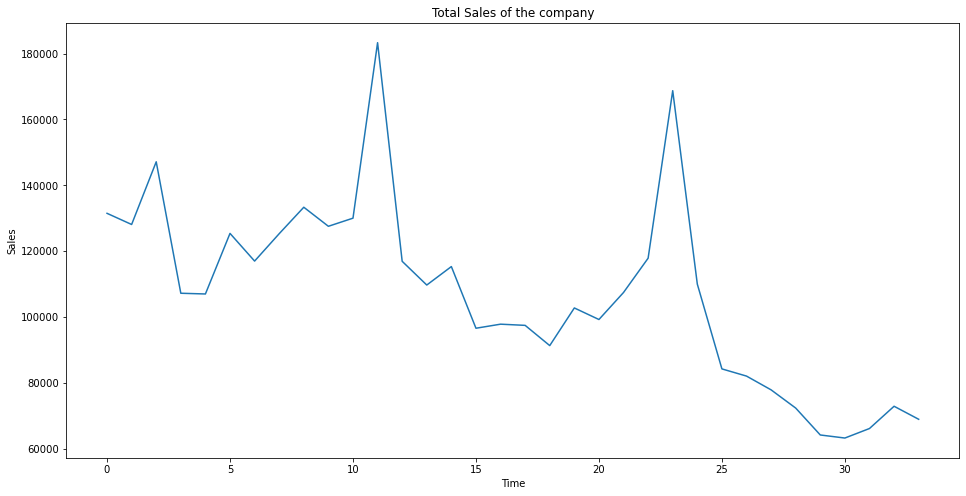

In [28]:
monthly_sales4.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(monthly_sales4);

In [33]:
# shop_id_list=list(set(train.shop_id))

In [34]:
# shop_id_list

In [35]:
# sns.pairplot(df, 
#              hue = "species" # helps to separate the values by specios
#             );

In [36]:
test

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268
...,...,...,...
214195,214195,45,18454
214196,214196,45,16188
214197,214197,45,15757
214198,214198,45,19648
